In [12]:
import glob, os
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
import matplotlib as mpl
from astropy import units as u
import speclite.filters
import time
import multiprocessing
from itertools import repeat

In [13]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 200
plt.rc('font', family='serif')

In [14]:
from helper import makeSpecColors
from helper import convert_flam2fnu
from helper import get_wollaeger
from helper import convert_app2abs
from helper import convert_abs2app
kncbtbl = get_wollaeger()
from helper import get_bandwidth_table
bdwtbl = get_bandwidth_table()
#	speclite
from helper import get_speclite_med
meds = get_speclite_med()
mlam = meds.effective_wavelengths
mbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Med']*u.Angstrom
from helper import get_speclite_sdss
sdss = get_speclite_sdss()
slam = sdss.effective_wavelengths
sbdw = bdwtbl['bandwidth'][bdwtbl['group']=='SDSS']*u.Angstrom
from helper import get_speclite_jc
jc = get_speclite_jc()
jclam = jc.effective_wavelengths
jcbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Johnson Cousin']*u.Angstrom
#
from helper import get_7dt_depth
from helper import get_7dt_broadband_depth
dptbl = get_7dt_depth(exptime=180)
# dptbl = get_7dt_broadband_depth(exptime=180)

In [15]:
# magoffset = -2.5*np.log10(54)
magoffset = -4.3
print(f"Apply magnitude offset ({magoffset:1.3f} mag)")

Apply magnitude offset (-4.300 mag)


In [16]:
#	Kilonova Simulated Photometry Table List for med-bands
knsimphtmedlist = sorted(glob.glob("../3.table/kn_sim_cube_synphot/Run*med.ecsv"))
knsimphtmed = knsimphtmedlist[0]
knsimphtmed
simtbl = ascii.read(knsimphtmed)
simtbl[:10]

t,m400,m425,m450,m475,m500,m525,m550,m575,m600,m625,m650,m675,m700,m725,m750,m775,m800,m825,m850,m875
d,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.125,-5.762,-5.692,-5.391,-5.480,-5.668,-6.135,-6.270,-6.146,-6.206,-6.203,-6.035,-6.078,-5.591,-5.664,-5.419,-5.733,-6.192,-6.091,-6.072,-6.241
0.136,-6.422,-6.387,-6.304,-6.332,-6.344,-6.579,-6.668,-6.588,-6.560,-6.559,-6.409,-6.497,-6.283,-6.254,-6.084,-6.190,-6.639,-6.436,-6.564,-6.643
0.149,-6.727,-6.707,-6.690,-6.705,-6.663,-6.721,-6.825,-6.704,-6.676,-6.708,-6.566,-6.677,-6.539,-6.487,-6.371,-6.434,-6.882,-6.683,-6.721,-6.801
0.162,-6.784,-6.774,-6.802,-6.773,-6.759,-6.823,-6.946,-6.845,-6.823,-6.883,-6.753,-6.872,-6.690,-6.620,-6.489,-6.622,-7.050,-6.883,-6.871,-6.969
0.177,-6.877,-6.881,-6.886,-6.859,-6.917,-7.058,-7.180,-7.077,-7.031,-7.077,-6.991,-7.087,-6.873,-6.820,-6.756,-6.813,-7.229,-7.077,-7.047,-7.198
0.193,-7.063,-7.027,-7.054,-7.037,-7.082,-7.248,-7.356,-7.266,-7.227,-7.259,-7.169,-7.245,-7.048,-7.039,-6.964,-6.990,-7.432,-7.252,-7.203,-7.348
0.21,-7.233,-7.196,-7.211,-7.211,-7.245,-7.398,-7.518,-7.439,-7.415,-7.429,-7.341,-7.438,-7.193,-7.175,-7.105,-7.151,-7.608,-7.406,-7.352,-7.473
0.229,-7.440,-7.388,-7.369,-7.394,-7.423,-7.574,-7.694,-7.619,-7.585,-7.594,-7.508,-7.602,-7.379,-7.314,-7.265,-7.326,-7.755,-7.550,-7.512,-7.597


In [17]:
snsimphtmed = '../3.table/sn_sim_sncosmo_synphot/hsaio_v3_type_1a_sn_synphot_med.ecsv'
simtbl = ascii.read(snsimphtmed)
simtbl[:10]

t,m400,m425,m450,m475,m500,m525,m550,m575,m600,m625,m650,m675,m700,m725,m750,m775,m800,m825,m850,m875
d,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
-5.0,-19.399,-19.097,-19.256,-18.986,-18.917,-18.979,-18.910,-18.970,-18.803,-18.825,-18.916,-18.749,-18.668,-18.589,-18.460,-18.528,-18.291,-18.321,-18.555,-18.511
-4.0,-19.474,-19.189,-19.352,-19.078,-19.002,-19.072,-19.004,-19.072,-18.906,-18.912,-19.008,-18.811,-18.714,-18.623,-18.468,-18.569,-18.390,-18.354,-18.641,-18.589
-3.0,-19.558,-19.252,-19.389,-19.110,-19.051,-19.141,-19.087,-19.160,-18.990,-18.984,-19.081,-18.844,-18.725,-18.624,-18.454,-18.597,-18.480,-18.358,-18.702,-18.626
-2.0,-19.603,-19.291,-19.423,-19.142,-19.092,-19.192,-19.145,-19.226,-19.060,-19.036,-19.128,-18.868,-18.729,-18.620,-18.438,-18.601,-18.516,-18.353,-18.739,-18.670
-1.0,-19.616,-19.309,-19.452,-19.174,-19.125,-19.227,-19.183,-19.273,-19.120,-19.072,-19.156,-18.885,-18.721,-18.605,-18.412,-18.579,-18.508,-18.338,-18.763,-18.738
0.0,-19.608,-19.322,-19.467,-19.193,-19.147,-19.250,-19.207,-19.303,-19.161,-19.093,-19.176,-18.897,-18.717,-18.586,-18.380,-18.552,-18.484,-18.311,-18.764,-18.776
1.0,-19.579,-19.332,-19.469,-19.200,-19.159,-19.264,-19.217,-19.316,-19.185,-19.095,-19.188,-18.903,-18.717,-18.565,-18.342,-18.527,-18.448,-18.277,-18.742,-18.786
2.0,-19.546,-19.321,-19.457,-19.193,-19.157,-19.271,-19.220,-19.322,-19.189,-19.085,-19.192,-18.902,-18.709,-18.543,-18.307,-18.504,-18.406,-18.231,-18.697,-18.767


In [18]:
knobsphtmedlist = sorted(glob.glob("../5.result/kn_sim_cube_obs/Run*med.ecsv"))
knobsphtmedlist
# knobsphtmed = knobsphtmedlist[5]
# knobsphtmed =  '../5.result/kn_sim_cube_obs/Run_TP_dyn_all_lanth_wind1_all_md0.03_vd0.3_mw0.01_vw0.05_angle0_synphot_med_obs_d80_iter100.med.ecsv'
knobsphtmed = 'Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.3_angle90_synphot_med_obs_d40_iter100.med.ecsv'
obstbl = ascii.read(knobsphtmed)
# knobsphtmed
obstbl[:10]

seed,t,magabs_m400,magapp_m400,snr_m400,magerr_m400,magobs_m400,fnu_m400,fnuobs_m400,fnuerr_m400,detection_m400,magabs_m425,magapp_m425,snr_m425,magerr_m425,magobs_m425,fnu_m425,fnuobs_m425,fnuerr_m425,detection_m425,magabs_m450,magapp_m450,snr_m450,magerr_m450,magobs_m450,fnu_m450,fnuobs_m450,fnuerr_m450,detection_m450,magabs_m475,magapp_m475,snr_m475,magerr_m475,magobs_m475,fnu_m475,fnuobs_m475,fnuerr_m475,detection_m475,magabs_m500,magapp_m500,snr_m500,magerr_m500,magobs_m500,fnu_m500,fnuobs_m500,fnuerr_m500,detection_m500,magabs_m525,magapp_m525,snr_m525,magerr_m525,magobs_m525,fnu_m525,fnuobs_m525,fnuerr_m525,detection_m525,magabs_m550,magapp_m550,snr_m550,magerr_m550,magobs_m550,fnu_m550,fnuobs_m550,fnuerr_m550,detection_m550,magabs_m575,magapp_m575,snr_m575,magerr_m575,magobs_m575,fnu_m575,fnuobs_m575,fnuerr_m575,detection_m575,magabs_m600,magapp_m600,snr_m600,magerr_m600,magobs_m600,fnu_m600,fnuobs_m600,fnuerr_m600,detection_m600,magabs_m625,magapp_m625,snr_m625,magerr_m625,magobs_m625,fnu_m625,fnuobs_m625,fnuerr_m625,detection_m625,magabs_m650,magapp_m650,snr_m650,magerr_m650,magobs_m650,fnu_m650,fnuobs_m650,fnuerr_m650,detection_m650,magabs_m675,magapp_m675,snr_m675,magerr_m675,magobs_m675,fnu_m675,fnuobs_m675,fnuerr_m675,detection_m675,magabs_m700,magapp_m700,snr_m700,magerr_m700,magobs_m700,fnu_m700,fnuobs_m700,fnuerr_m700,detection_m700,magabs_m725,magapp_m725,snr_m725,magerr_m725,magobs_m725,fnu_m725,fnuobs_m725,fnuerr_m725,detection_m725,magabs_m750,magapp_m750,snr_m750,magerr_m750,magobs_m750,fnu_m750,fnuobs_m750,fnuerr_m750,detection_m750,magabs_m775,magapp_m775,snr_m775,magerr_m775,magobs_m775,fnu_m775,fnuobs_m775,fnuerr_m775,detection_m775,magabs_m800,magapp_m800,snr_m800,magerr_m800,magobs_m800,fnu_m800,fnuobs_m800,fnuerr_m800,detection_m800,magabs_m825,magapp_m825,snr_m825,magerr_m825,magobs_m825,fnu_m825,fnuobs_m825,fnuerr_m825,detection_m825,magabs_m850,magapp_m850,snr_m850,magerr_m850,magobs_m850,fnu_m850,fnuobs_m850,fnuerr_m850,detection_m850,magabs_m875,magapp_m875,snr_m875,magerr_m875,magobs_m875,fnu_m875,fnuobs_m875,fnuerr_m875,detection_m875
,d,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,f

In [19]:
t = 1.0
seed = 1
#	Part obs. Table
pobstbl = obstbl[
	(obstbl['t']==t) &
	(obstbl['seed']==seed)
]
pobstbl

seed,t,magabs_m400,magapp_m400,snr_m400,magerr_m400,magobs_m400,fnu_m400,fnuobs_m400,fnuerr_m400,detection_m400,magabs_m425,magapp_m425,snr_m425,magerr_m425,magobs_m425,fnu_m425,fnuobs_m425,fnuerr_m425,detection_m425,magabs_m450,magapp_m450,snr_m450,magerr_m450,magobs_m450,fnu_m450,fnuobs_m450,fnuerr_m450,detection_m450,magabs_m475,magapp_m475,snr_m475,magerr_m475,magobs_m475,fnu_m475,fnuobs_m475,fnuerr_m475,detection_m475,magabs_m500,magapp_m500,snr_m500,magerr_m500,magobs_m500,fnu_m500,fnuobs_m500,fnuerr_m500,detection_m500,magabs_m525,magapp_m525,snr_m525,magerr_m525,magobs_m525,fnu_m525,fnuobs_m525,fnuerr_m525,detection_m525,magabs_m550,magapp_m550,snr_m550,magerr_m550,magobs_m550,fnu_m550,fnuobs_m550,fnuerr_m550,detection_m550,magabs_m575,magapp_m575,snr_m575,magerr_m575,magobs_m575,fnu_m575,fnuobs_m575,fnuerr_m575,detection_m575,magabs_m600,magapp_m600,snr_m600,magerr_m600,magobs_m600,fnu_m600,fnuobs_m600,fnuerr_m600,detection_m600,magabs_m625,magapp_m625,snr_m625,magerr_m625,magobs_m625,fnu_m625,fnuobs_m625,fnuerr_m625,detection_m625,magabs_m650,magapp_m650,snr_m650,magerr_m650,magobs_m650,fnu_m650,fnuobs_m650,fnuerr_m650,detection_m650,magabs_m675,magapp_m675,snr_m675,magerr_m675,magobs_m675,fnu_m675,fnuobs_m675,fnuerr_m675,detection_m675,magabs_m700,magapp_m700,snr_m700,magerr_m700,magobs_m700,fnu_m700,fnuobs_m700,fnuerr_m700,detection_m700,magabs_m725,magapp_m725,snr_m725,magerr_m725,magobs_m725,fnu_m725,fnuobs_m725,fnuerr_m725,detection_m725,magabs_m750,magapp_m750,snr_m750,magerr_m750,magobs_m750,fnu_m750,fnuobs_m750,fnuerr_m750,detection_m750,magabs_m775,magapp_m775,snr_m775,magerr_m775,magobs_m775,fnu_m775,fnuobs_m775,fnuerr_m775,detection_m775,magabs_m800,magapp_m800,snr_m800,magerr_m800,magobs_m800,fnu_m800,fnuobs_m800,fnuerr_m800,detection_m800,magabs_m825,magapp_m825,snr_m825,magerr_m825,magobs_m825,fnu_m825,fnuobs_m825,fnuerr_m825,detection_m825,magabs_m850,magapp_m850,snr_m850,magerr_m850,magobs_m850,fnu_m850,fnuobs_m850,fnuerr_m850,detection_m850,magabs_m875,magapp_m875,snr_m875,magerr_m875,magobs_m875,fnu_m875,fnuobs_m875,fnuerr_m875,detection_m875
,d,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,f

In [20]:
psimtbl = simtbl[
	#	Kilonova
	# (simtbl['t']==1.0)
	#	Supernova Type Ia
	(simtbl['t']==10)
]
psimtbl

t,m400,m425,m450,m475,m500,m525,m550,m575,m600,m625,m650,m675,m700,m725,m750,m775,m800,m825,m850,m875
d,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10.0,-18.945,-18.816,-19.006,-18.803,-18.741,-19.155,-19.020,-18.934,-18.888,-18.688,-18.874,-18.481,-18.249,-18.142,-17.834,-18.036,-18.011,-17.465,-18.332,-18.606


In [21]:
# fnuabs = [pobstbl[f"{filte}"].item() for filte in pobstbl.keys() if 'fnu_' in filte]
fnuabs = [(psimtbl[f"{filte}"].item()*u.ABmag).to(u.uJy).value for filte in psimtbl.keys() if 'm' in filte]
#	Answer
fnuabs_anwr = [(pobstbl[f"{filte}"].item()*u.ABmag).to(u.uJy).value for filte in pobstbl.keys() if 'magabs' in filte]
fnuobs = [pobstbl[f"{filte}"].item() for filte in pobstbl.keys() if 'fnuobs_' in filte]
fnuobserr = [pobstbl[f"{filte}"].item() for filte in pobstbl.keys() if 'fnuerr_' in filte]

In [22]:
from scipy.optimize import curve_fit

def func(x, a):
	return a*x

def calc_chisquare(obs, exp):
	return np.sum((obs-exp)**2/exp)


In [23]:
popt, pcov = curve_fit(func, fnuabs, fnuobs, sigma=fnuobserr, absolute_sigma=True,)

popt_anwr, pcov_anwr = curve_fit(func, fnuabs_anwr, fnuobs, sigma=fnuobserr, absolute_sigma=True,)


In [24]:
chisq = calc_chisquare(
	# obs=func(fnuabs, *popt),
	obs=fnuabs*popt,
	exp=fnuobs,
	)

chisq_anwr = calc_chisquare(
	# obs=func(fnuabs, *popt),
	obs=fnuabs_anwr*popt_anwr,
	exp=fnuobs,
	)

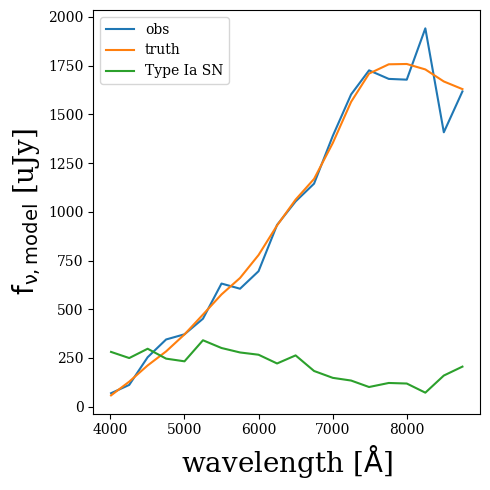

In [25]:
fig = plt.figure(figsize=(5, 5))

plt.plot(mlam, fnuobs, label='obs')
plt.plot(mlam, fnuabs_anwr*popt_anwr, label='truth')
plt.plot(mlam, fnuabs*popt, label='Type Ia SN')

plt.xlabel(r'wavelength [$\rm \AA$]')
plt.ylabel(r'$\rm f_{\nu, model}$ [uJy]')
plt.legend()
plt.tight_layout()

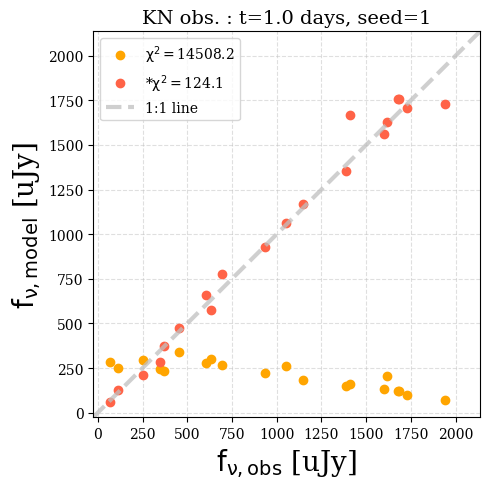

In [26]:
fig = plt.figure(figsize=(5, 5))
plt.title(f"KN obs. : t={t:1.1f} days, seed={seed}")
# plt.plot(fnuobs, fnuabs)
# plt.plot(func(fnuabs, *popt), fnuobs, ls='none', c='orange', marker='o', label='Fitting')
plt.plot(fnuobs, fnuabs*popt, ls='none', c='orange', marker='o', label=r'$\rm \chi^{2}=$'+f'{chisq:1.1f}')
plt.plot(fnuobs, fnuabs_anwr*popt_anwr, ls='none', c='tomato', marker='o', label=r'*$\rm \chi^{2}=$'+f'{chisq_anwr:1.1f}')


xl, xr = plt.xlim()
plt.xlim([xl, xr*1.05])
plt.ylim([xl, xr*1.05])

plt.plot([xl, xr*1.1], [xl, xr*1.1], ls='--', color='silver', lw=3, label='1:1 line', alpha=0.75)
plt.legend()
plt.xlabel(r'$\rm f_{\nu, obs}$ [uJy]')
plt.ylabel(r'$\rm f_{\nu, model}$ [uJy]')
plt.tight_layout()
plt.grid('both', ls='--', c='silver', alpha=0.5)